# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

# Import libraries 

In [1]:
import torch
import imageio
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

## Device and random seed

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")
random_seed = 1234
torch.manual_seed(random_seed)

Device used: cuda


## Load Data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/heat_transfer_finn.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields_G = ['G']
fields = fields_T + fields_G
df = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
df_train, df_test = train_test_split(df, test_size = split_ratio, random_state=random_seed)

# Convert into numpy arrays
X_train, Y_train = (df_train[fields_T].to_numpy(), df_train[fields_G].to_numpy())
X_test, Y_test = (df_test[fields_T].to_numpy(), df_test[fields_G].to_numpy())

# Print shapes
print("X_test information:")
print("the size of X_test is", X_test.size)
print("the shape of X_test is", X_test.shape)

print("X_train information:")
print("the size of X_train is", X_train.size)
print("the shape of X_train is", X_train.shape)

print("Y_train information:")
print("the size of Y_train is", Y_train.size)
print("the shape of Y_train is", Y_train.shape)

print("Y_test information:")
print("the size of Y_test is", Y_test.size)
print("the shape of Y_test is", Y_test.shape)

X_test information:
the size of X_test is 900
the shape of X_test is (100, 9)
X_train information:
the size of X_train is 3600
the shape of X_train is (400, 9)
Y_train information:
the size of Y_train is 400
the shape of Y_train is (400, 1)
Y_test information:
the size of Y_test is 100
the shape of Y_test is (100, 1)


### Normalization $\overline{\theta[i,j]} = 2\frac{\theta[i,j] \min(\theta[:,j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$ functions:

In [4]:
def normalize_ij(xi, xmax, xmin):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array):
    """
    Normalize an array by columns computing the max and min of each column.
    
    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    min_X_cols = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_X_cols = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    normalized_X_array = np.zeros_like(X_array)
    
    # Fill the copy vector
    for col in range(num_col_X): 
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], max_X_cols[col] , min_X_cols[col])
        
    return normalized_X_array, min_X_cols, max_X_cols

### Creates a customizable architecture NN

In [5]:
def create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers):
    """
    Function to create a sequentual NN model.

    Parameters:
       dim_input (int):                      Input dimension (number of features).
       dim_output (int):                     Output dimension (number of features).
       num_hidden_layers(int):               Number of hidden layers.
       nun_nuerons_hidden_layers (int):      Number of hidden layers.   
   """      
    # create an empty sequentail model
    Net = torch.nn.Sequential()

    # Add first layer 
    Net.add_module("input_layer", torch.nn.Linear(dim_input, nun_nuerons_hidden_layers))
     
    # Add hidden layers
    for nhidden_layer in range(num_hidden_layers):
        Net.add_module(
            "hidden_layer_num_{}".format(nhidden_layer + 1),
            torch.nn.Linear(nun_nuerons_hidden_layers, nun_nuerons_hidden_layers)
        )
        Net.add_module("hidden_activation_num_{}".format(nhidden_layer + 1 ), torch.nn.LeakyReLU())

    # Add output layer
    Net.add_module("output_layer", torch.nn.Linear(nun_nuerons_hidden_layers, dim_output))
        
    return Net

## Train and test function: ` train_test_model `

In [6]:
def train_test_model(
    num_data_training, 
    nun_nuerons_hidden_layers, num_hidden_layers,
    num_epochs,
    X_train, Y_train, X_test, Y_test,
    device,
    generate_gif = False,
    normalize_bool = True):
    """
    Function to build, test and train the model.

    Parameters:
       num_data_trainging (int):        Number of samples.
       nun_nuerons_hidden_layers (int): Number of neurons for each hidden layer.
       num_hidden_layers (int):         Number of hidden layers.
       num_epochs (int):                Number of epochs to train the model.   
       X_train (ndarray):               Numpy array contaning the traning set inputs.   
       Y_train (ndarray):               Numpy array contaning the training set outputs.   
       X_test (ndarray):                Numpy array contaning the testing set inputs.   
       Y_test (ndarray):                Numpy array contaning the testing set outputs. 
       device (string):                 'cpu' or 'cuda'
       generate_gif (bool):             Boolean to generate a training .gif.
       nromalize_bool (bool):           Boolean to normalize the input data.

   """        
    
    ###############################################
    ############# TRAINING STAGE ##################
    ###############################################
    
    # Pick the first num data trainig samples for X and Y
    X_train_reduced = X_train[:num_data_training,1:] # Skip the first value since no adds any extra info
    num_col_Xr = X_train_reduced.shape[1]
    Y_train_reduced = Y_train[:num_data_training]
    num_col_Y = Y_train_reduced.shape[1]
    
    # Normalize X_train
    if normalize_bool:
        normalized_X_reduced_train, _, _ = normalize(X_train_reduced)
    else:
        normalized_X_reduced_train = X_train_reduced

    
    # Transofrm from numpy to torch into torch x_train and y_train 
    x_to_plot = normalized_X_reduced_train.reshape(-1,num_col_Xr)             
    x_train = torch.from_numpy(x_to_plot).float().to(device)
    y_train = torch.from_numpy(Y_train_reduced.reshape(-1,num_col_Y)).float().to(device)
    
    # Define model architecture and copy the model to device
    dim_input = x_train.shape[1]
    dim_output = num_col_Y
    Net = create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers)
    Net.to(device)
    
    # Watch x,y variables into torch
    x_train = Variable(x_train)
    y_train = Variable(y_train)
    
    # Training parameters
    loss_function = torch.nn.MSELoss()
    LearningRate = 1e-4
    adam_only_loss = np.zeros(num_epochs)

    # Define optimizer
    optimizer_adam = torch.optim.Adam(Net.parameters(), lr = LearningRate)

    # Image
    if generate_gif:
        fig, ax = plt.subplots(figsize=(15,10))
        image_list = []

    # Initialize variable to measure time
    start_time = time.time()
    
    # Train the model
    for epoch in range(num_epochs):
        y_pred = Net(x_train)
        loss = loss_function(y_pred, y_train)  # Notice the order: NN Pred first and then actual value
        optimizer_adam.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer_adam.step()
        adam_only_loss[epoch] = loss.to('cpu').detach().numpy()
        
        # Print gif for a 50 epochs step
        if epoch%50==0 and generate_gif:
        
            # Temperature index to plot 
            temp_to_plot_idx = 0 #[ 0 => T1, 1 => T2]
            # Compute testing values to plot
            X_test_reduced = X_test[:,1:] # Skip the first temperature
            if normalize_bool:
                normalized_X_test, _, _ = normalize(X_test_reduced)
            else:
                normalized_X_test = X_test_reduced

            x_test_to_plot = normalized_X_test[:,temp_to_plot_idx].reshape(-1,1)
            y_test = (Y_test.reshape(-1,num_col_Y))

            
            # Compute training values to plot 
            x_train_cpu = x_train.to('cpu').detach().numpy()
            x_train_to_plot = x_train_cpu[:,temp_to_plot_idx].reshape(-1,1)
            y_train_to_plot = y_train.to('cpu').detach().numpy()
            
            y_pred_to_plot = y_pred.to('cpu').detach().numpy()
            
            # Plot
            plt.cla()
            ax.scatter(x_test_to_plot, y_test, color = "red", label="Testing Data")
            ax.scatter(x_train_to_plot, y_train_to_plot, color = "blue", label="Training Data")
            ax.plot(x_train_to_plot[:,0], y_pred_to_plot, 'k--', lw=2,  label="NN Apprximated")
            
            # Labels
            if normalize_bool:
                ax.set_xlabel(r'$norm\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
            else:
                ax.set_xlabel(r'$\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
                
            ax.set_ylabel('$G$', fontsize=32)
            ax.set_xlim(min(x_test_to_plot), max(x_test_to_plot))
            ax.set_ylim(0, 1)

            
            ax.text(min(x_test_to_plot), 1 , 'Adam Optimizer: epoch = %d,' %epoch, fontdict={'size': 22, 'color':  'black'})
            ax.text(min(x_test_to_plot) + (max(x_test_to_plot) - min(x_test_to_plot))/2, 1, 'Loss = %.6f' % loss,
                    fontdict={'size': 22, 'color':  'black'})
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.legend()

            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            image_list.append(image)

    
    elapsed_time = time.time() - start_time
    
    if generate_gif:
        name = './part1_outputs/gifs/Adam_ndata_{}_nhlayers_{}_nromalized_{}.gif'.format(num_data_training, num_hidden_layers, normalize_bool)
        imageio.mimsave(name, image_list, fps=5)
    
    print(f"With num_data_training: {num_data_training} the final loss is: {loss:.5e}")

    
    ###############################################
    ############# TESTING STAGE ##################
    ###############################################
    # Normalize X_test
    X_test_reduced = X_test[:,1:] # Skip the first temperature
    if normalize_bool:
        normalized_X_test, _, _ = normalize(X_test_reduced)
    else:
        normalized_X_test = X_test_reduced
    
    # Convert into torch x_test and y_test 
    x_test = torch.from_numpy(normalized_X_test.reshape(-1,num_col_Xr)).float().to(device)
    y_test = torch.from_numpy(Y_test.reshape(-1,num_col_Y)).float().to(device)

    # Compute y predict
    y_nn = Net(x_test)
    error_test = loss_function(y_nn, y_test).to('cpu').detach().numpy()  # Notice the order: NN Pred first and then actual value

    return adam_only_loss, error_test, elapsed_time, Net

## Plot data function

In [7]:
def plot_data_vs_G(X_train, Y_train, fig_name, label_size = 14, marker_size = 5):
  """
  Function to plot some temperature vs G .

  Parameters:
      X_train (ndarray):  Xtrain data set.
      Y_train (ndarray):  Y_train data set.
      fig_name (string):  figure name.
      label_size(int):    xtics and legend label size
      marker_size(int):   xticks and legend marker size
  """        

  ## Make a subplot with 2 figures
  fig, ax = plt.subplots(1, 2, figsize=(15, 7))

  # Plot the first figure [thteta1, ..., theta9] vs G
  num_sample_plots = 100
  aux_ones = np.ones((X_train.shape[1],))
  samples_plotted = []

  while len(samples_plotted) <= num_sample_plots:
      sample_picked = np.random.randint(0, X_train.shape[0])
      if sample_picked not in samples_plotted:
          G_sample = Y_train[sample_picked]
          Y_plot = G_sample * aux_ones
          label = "G = {}".format(G_sample)
          ax[0].scatter(X_train[sample_picked,:], Y_plot, label = label, s = marker_size)
          samples_plotted.append(sample_picked)

  if X_train.mean() <=10:
    ax[0].set_xlabel(r'$[\theta_1,... \theta_9]$', fontsize = 1.8*label_size)
  else:
    ax[0].set_xlabel(r'$[T_1,... T_9]$', fontsize = 1.8*label_size)
      
  ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
  ax[0].tick_params(axis='both', which='major', labelsize=label_size)


  # Plot the second figure theta vs x
  samples_plotted = []
  x_train_reduced = X_train[:,1:]
  _, min_theta_reduced, max_theta_reduced = normalize(x_train_reduced)

  for i in range(num_sample_plots):
    picked = np.random.randint(0, X_train.shape[1]) 
    if sample_picked not in samples_plotted:
      label =  'G = {}'.format(Y_train[picked])
      ax[1].plot(X_train[picked,:],label=label)

  x_reduced = range(1,9)
  ax[1].plot(x_reduced, min_theta_reduced, 'k-o' ,label = 'min')
  ax[1].plot(x_reduced, max_theta_reduced, 'k-o',label = 'max')
  ax[1].set_ylabel(r'$\theta$', fontsize = 1.8*label_size)
  ax[1].set_xlabel(r'$x*$', fontsize = 1.8*label_size)
  ax[1].tick_params(axis='both', which='major', labelsize=label_size)

  # Save and show thefigure
  fig.savefig(fig_name, bbox_inches='tight')
  plt.show()

### Plot $T(x)$ and $[T_1, ..., T_9]$ for different $G$ values

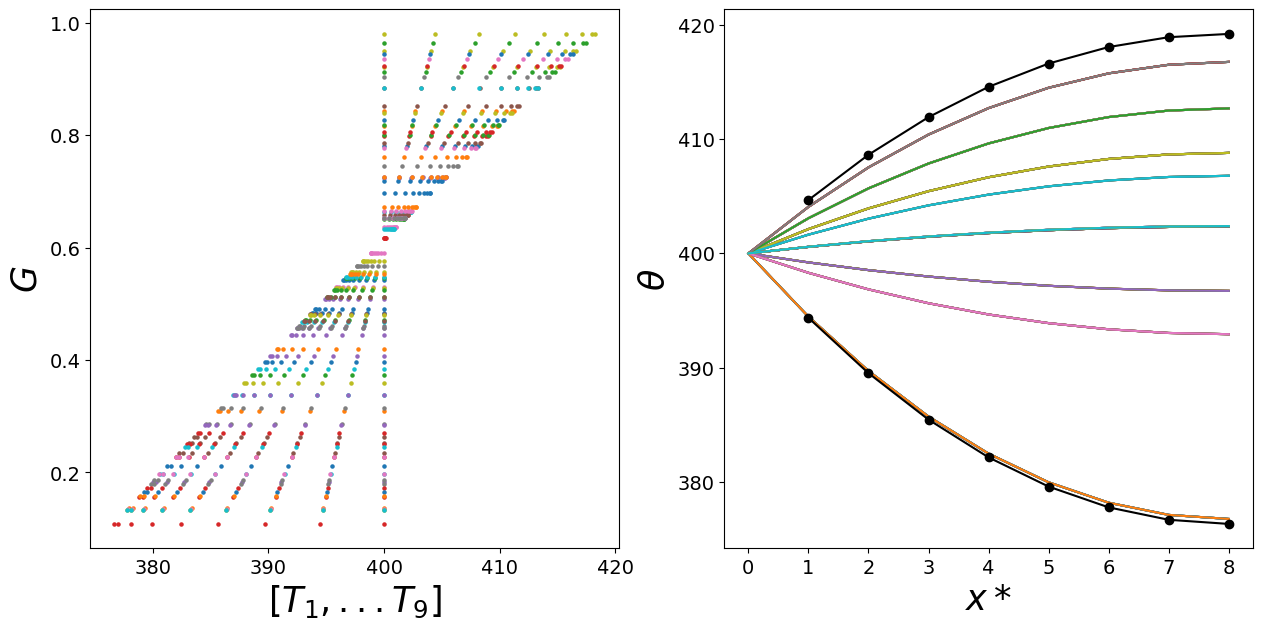

In [8]:
plot_data_vs_G(X_train, Y_train, './part1_outputs/figures/T_vs_G.png') 

## Compute $\theta$ as: `X_train`

In [9]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
Theta_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

## G vs $[\theta_1, \theta_2,... \theta_9]$ and $\theta(x)$

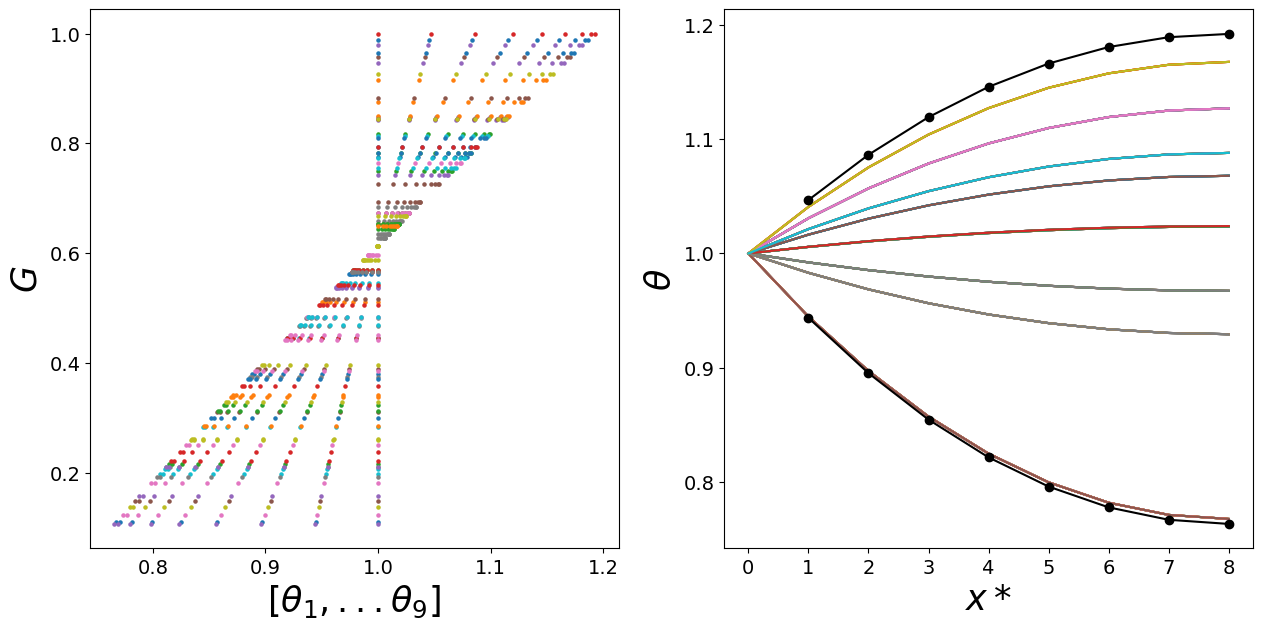

In [10]:
plot_data_vs_G(Theta_train, Y_train, './part1_outputs/figures/Theta_vs_G.png')

## Plot nromalized and reduced $\theta(x)$ for different G values 

Text(0.5, 0, '$[\\theta_1,... \\theta_9]$')

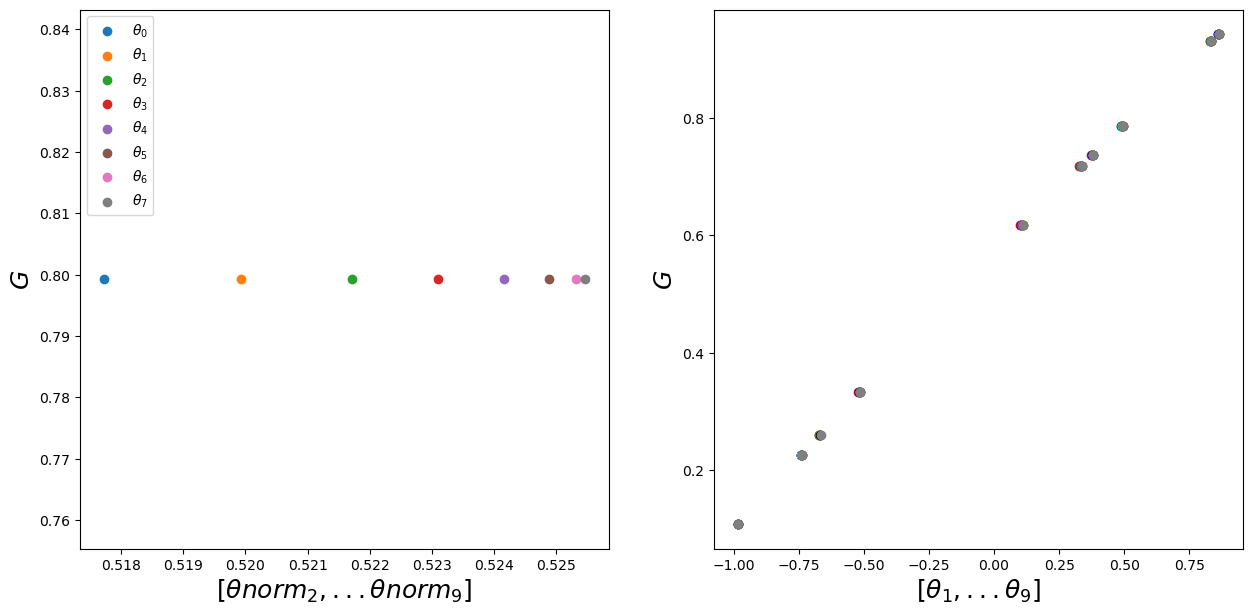

In [11]:
# Normalize and reduce theta 
theta_train_reduced = Theta_train[:,1:]
theta_train_reduced_normalized, min_theta, max_theta = normalize(theta_train_reduced)


## Make a subplot with 2 figures
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot parameters
num_sample_plots = 10
label_size = 10

## Plot one random sample of Theta vs G

picked = np.random.randint(0,400,1)
ax[0].cla()
for col in range(theta_train_reduced_normalized.shape[1]):
    aux_ones = np.ones((theta_train_reduced_normalized.shape[0],))
    label = r"$\theta_{}$".format(col)
    ax[0].scatter(theta_train_reduced_normalized[picked, col], Y_train[picked], label = label)   

ax[0].set_xlabel(r'$[\theta norm_2,... \theta norm_9]$', fontsize = 1.8*label_size)
ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[0].legend(loc='upper left', fontsize = 10)

aux_ones = np.ones((theta_train_reduced_normalized.shape[1],))
picked = np.random.randint(0,400,num_sample_plots)


col_colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'gray']
for col in range(theta_train_reduced_normalized.shape[1]):
    for it in range(num_sample_plots):
        x = theta_train_reduced_normalized[picked[it], col] 
        y = Y_train[picked[it]]
        ax[1].scatter(x, y, color = col_colors[col])

ax[1].set_xlabel(r'$[\theta norm_2,... \theta norm_9]$', fontsize = 1.8*label_size)
ax[1].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)
plt.xlabel(r'$[\theta_1,... \theta_9]$')

## Train the model for different number of  $\theta$ data training

In [12]:
# model hyper-params
num_epochs = 8000
num_of_neurons = 32
num_of_hidden_layers = 2

# range for number of data training
nun_data_training = range(10,400,10)

In [13]:
# Paramters to select
normalization_bool = True
plot_gif_bool = False

# result arrays to be filled
testing_error = np.zeros(len(nun_data_training))
elapsed_time_cpu = np.zeros_like(testing_error)
loss = np.zeros((len(nun_data_training),num_epochs))

## GPU execution
device = 'cuda'
elapsed_time_gpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss[i,:], testing_error[i], elapsed_time_gpu[i], _ = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, X_train, Y_train, X_test, Y_test, device)
    
    
## CPU execution
device = 'cpu'
elapsed_time_cpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss_train[i,:], loss_test[i], elapsed_time_cpu[i], _ = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, Theta_train, Y_train, Theta_test, Y_test,
        device, plot_gif_bool, normalization_bool)


Training with : cuda
With num_data_training: 10 the final loss is: 6.92027e-08
With num_data_training: 20 the final loss is: 4.38971e-07
With num_data_training: 30 the final loss is: 3.02897e-08
With num_data_training: 40 the final loss is: 1.04892e-07
With num_data_training: 50 the final loss is: 1.55028e-07
With num_data_training: 60 the final loss is: 3.57490e-08
With num_data_training: 70 the final loss is: 5.37161e-08
With num_data_training: 80 the final loss is: 3.02949e-07
With num_data_training: 90 the final loss is: 3.12051e-08
With num_data_training: 100 the final loss is: 4.28818e-08
With num_data_training: 110 the final loss is: 5.18178e-08
With num_data_training: 120 the final loss is: 5.34905e-08
With num_data_training: 130 the final loss is: 4.04027e-08
With num_data_training: 140 the final loss is: 1.64641e-07
With num_data_training: 150 the final loss is: 1.28657e-07
With num_data_training: 160 the final loss is: 8.53561e-08
With num_data_training: 170 the final loss i

## Loss vs num epochs normalized

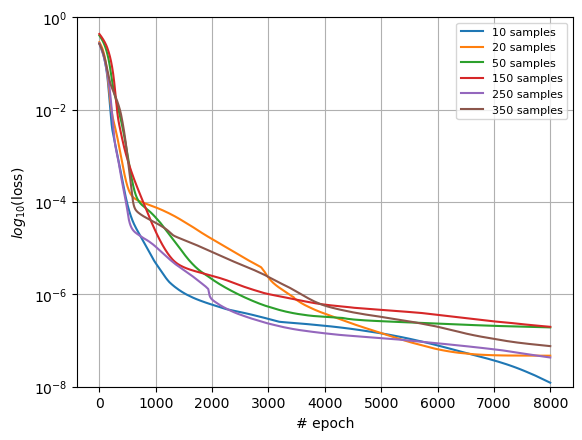

In [14]:
num_data_plot = 5
# pick unique num data point
num_data_training_rand = np.unique(np.random.choice(nun_data_training, num_data_plot))
num_data_training_rand = np.array([10, 20, 50, 150, 250, 350])

ax = plt.cla()

for num_data_training_plot_case in num_data_training_rand:
    index_ndata = np.where(nun_data_training == num_data_training_plot_case)
    label = "{} samples".format(num_data_training_plot_case)     
    plt.plot(range(num_epochs), loss[index_ndata[0][0],:], label=label)

plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
plt.ylim(1e-8, 1e0)
plt.savefig('part1_outputs/figures/loss_vs_nepoch.png')
plt.show()


## Test error vs number of data training samples

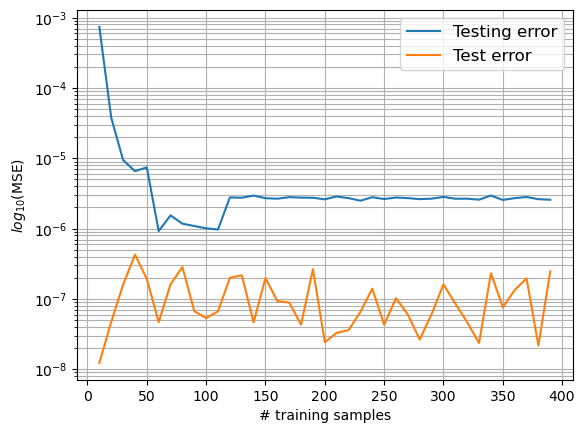

In [15]:
plt.plot(nun_data_training, testing_error, label="Testing error")
mean_loss = [ np.mean(loss[row,-11:-1])  for row in range(loss.shape[0])] 
plt.plot(nun_data_training, mean_loss, label="Test error")
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# training samples')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/test_train_error.png')
plt.show()

## Elapsed time vs num data trainig 

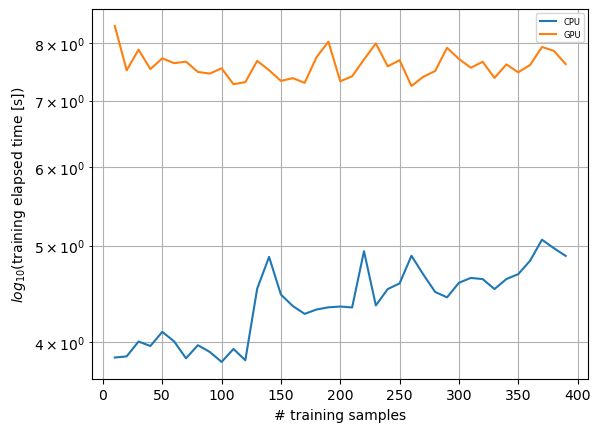

In [16]:
plt.plot(nun_data_training, elapsed_time_cpu, label = 'CPU')
plt.plot(nun_data_training, elapsed_time_gpu, label = 'GPU')
plt.legend(loc='upper right', prop={'size': 6})
plt.yscale('log')
plt.xlabel('# training samples')
plt.ylabel(r'$log_{10}$(training elapsed time [s])')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/exec_time.png')
plt.show()

## Train the model for different number of hidden layers 

In [17]:
# range for number of data training
num_hidden_layers_range = range(2,20,4)

# selected device
device = 'cpu'

# bolean to normalize
normalize_bool = True

# boolean to generate gifs
generate_gif = False

# model hyper-params
num_data_training = 400

# result arrays to be filled
testing_error = np.zeros(len(num_hidden_layers_range))
elapsed_time = np.zeros_like(testing_error)
loss_layers = np.zeros((len(num_hidden_layers_range),num_epochs))
nets = []

for i,num_hidden_layers in enumerate(num_hidden_layers_range):
    loss_layers[i,:], testing_error[i], elapsed_time[i], net = train_test_model(
        num_data_training, num_of_neurons, num_hidden_layers, num_epochs,
        X_train, Y_train, X_test, Y_test, device, generate_gif, normalize_bool)
    nets.append(net)    

With num_data_training: 400 the final loss is: 2.00736e-07
With num_data_training: 400 the final loss is: 1.36224e-08
With num_data_training: 400 the final loss is: 6.01379e-09
With num_data_training: 400 the final loss is: 8.97898e-09
With num_data_training: 400 the final loss is: 3.89989e-09


## Num of hidden layers vs errors (test, train)

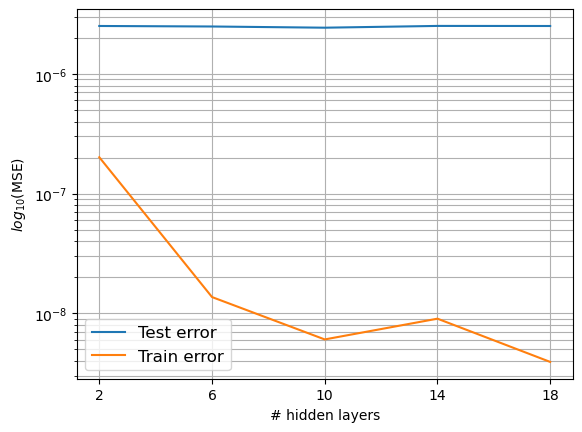

In [18]:
plt.plot(num_hidden_layers_range, testing_error, label="Test error")
plt.xticks(num_hidden_layers_range)  # Set label locations.
mean_loss = [ np.mean(loss_layers[row,-11:-1])  for row in range(loss_layers.shape[0])] 
plt.plot(num_hidden_layers_range, mean_loss, label="Train error")
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# hidden layers')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/hiddden_layer_analysis.png')
plt.show()